# Preliminaries
<a href="https://colab.research.google.com/github/cwf2/dices-mta/blob/main/Mother%20speech.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import pandas as pd
import requests
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA
from IPython.display import HTML

# Data
#### remote data    
Pre-prepared data saved in the GitHub repo

In [3]:
local_path = 'data'
remote_path = 'https://github.com/cwf2/dices-mta/raw/main/data/'
data_files = ['merged.csv', 'mother-child.csv', 'mother_diction.csv']

if not os.path.exists(local_path):
    os.mkdir(local_path)
for filename in data_files:
    if not os.path.exists(os.path.join(local_path, filename)):
        print(f'downloading {filename}')
        res = requests.get(remote_path + filename, json={"download":""})
        if not res.ok:
            res.raise_for_status()
        with open(os.path.join(local_path, filename), 'wb') as f:
            f.write(res.content)

### token table

In [73]:
tokens_file = os.path.join(local_path, 'merged.csv')
tokens = pd.read_csv(tokens_file, dtype=str)
display(tokens)

,speech_id,lang,author,work,urn,l_fi,l_la,nlines,spkr,addr,...,mood_cltk,tense_cltk,voice_cltk,aspect,person_cltk,number_cltk,case_cltk,gender_cltk,degree_cltk,verbform_cltk
0,1,greek,Homer,Iliad,urn:cts:greekLit:tlg0012.tlg001.perseus-grc2,1.17,1.21,5,Chryses,"Agamemnon,Greeks",...,NaN,NaN,NaN,NaN,NaN,plural,nominative,masculine,NaN,NaN
1,1,greek,Homer,Iliad,urn:cts:greekLit:tlg0012.tlg001.perseus-grc2,1.17,1.21,5,Chryses,"Agamemnon,Greeks",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,greek,Homer,Iliad,urn:cts:greekLit:tlg0012.tlg001.perseus-grc2,1.17,1.21,5,Chryses,"Agamemnon,Greeks",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,greek,Homer,Iliad,urn:cts:greekLit:tlg0012.tlg001.perseus-grc2,1.17,1.21,5,Chryses,"Agamemnon,Greeks",...,NaN,NaN,NaN,NaN,NaN,plural,nominative,masculine,NaN,NaN
4,1,greek,Homer,Iliad,urn:cts:greekLit:tlg0012.tlg001.perseus-grc2,1.17,1.21,5,Chryses,"Agamemnon,Greeks",...,NaN,NaN,NaN,NaN,NaN,plural,nominative,masculine,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
376382,4696,latin,Prudentius,Psychomachia,urn:cts:latinLit:stoa0238.stoa002.perseus-lat2,1.799,1.822,24,Fides,Virtues,...,NaN,NaN,NaN,NaN,NaN,plural,dative,feminine,NaN,NaN
376383,4696,latin,Prudentius,Psychomachia,urn:cts:latinLit:stoa0238.stoa002.perseus-lat2,1.799,1.822,24,Fides,Virtues,...,NaN,NaN,NaN,NaN,NaN,singular,accusative,feminine,NaN,NaN
376384,4696,latin,Prudentius,Psychomachia,urn:cts:latinLit:stoa0238.stoa002.perseus-lat2,1.799,1.822,24,Fides,Virtues,...,subjunctive,present,active,imperfective,third,singular,NaN,NaN,NaN,finite
376385,4696,latin,Prudentius,Psychomachia,urn:cts:latinLit:stoa0238.stoa002.perseus-lat2,1.799,1.822,24,Fides,Virtues,...,NaN,NaN,passive,perfective,NaN,singular,nominative,feminine,NaN,participle


### List of mother-child pairs

In [74]:
mothers_file = os.path.join(local_path, 'mother-child.csv')
mothers = pd.read_csv(mothers_file, sep='\t')
display(mothers)

,spkr,addr
0,Alcimede,Jason
1,Aphrodite,Eros
2,Aura (nymph),children of Aura
3,Chalciope,Argus (son of Phrixus)
4,Chalciope,sons of Phrixus
5,Chariclo,Tiresias
6,Leto,Apollo
7,Ceres,Proserpina
8,Cybele,Ceres
9,Venus,Cupid


### Identify mother speeches

This custom function checks the speaker and addressee instances of a speech against the list of mother-child pairs.

In [75]:
def motherValidation(rec):
    '''check whether any speaker-addressee combo is in the mother-child list'''
    valid_keys = list(mothers.spkr + ':' + mothers.addr)

    if rec['spkr'] is np.NaN:
        return False
    if rec['addr'] is np.NaN:
        return False

    for spkr in str(rec['spkr']).split(','):
        for addr in str(rec['addr']).split(','):
            key = f'{spkr}:{addr}'
            if key in valid_keys:
                return True

    return False

#### Add `mother` column

Add boolean mother flag to the token table

In [76]:
# validate mother-child pairs by speech instead of by token
by_speech = tokens.groupby(['spkr', 'addr'], sort=False).first().reset_index()
by_speech['mother'] = by_speech.apply(motherValidation, axis=1)

# apply results to the whole table
tokens = tokens.merge(by_speech[['spkr', 'addr', 'mother']], on=['spkr', 'addr'], how='left')

#### How many mother speeches?

In [77]:
tokens.groupby('speech_id').agg(speech_id=('speech_id', 'first'), mother=('mother', 'first')).groupby('mother').agg(count=('speech_id', 'count'))

,count
mother,
False,4030
True,94


## Hand-selected feature sets

In [78]:
class_file = os.path.join('data', 'mother_diction.csv')
lemma_class = pd.read_csv(class_file)

In [79]:
lem_dict = dict()

for label in lemma_class.label.unique():
    if not pd.isna(label):
        lem_dict[label] = lemma_class.loc[lemma_class.label == label, 'lemma'].values
        print(label, ':', sep="")
        print(*lem_dict[label], sep=" ")
        print()

family:
'nate altricus altrix avus auus coniunx coniux filius frater Frater fraterque gemina genetrix genitor genus infans mater matr maternus matrisque nao nascor Nata Nate natus no parens pario partus pater paternus patriosque patrius patruum pietas proavum progeo proles puer soror spons αἶμαι ἄλοχος ἀμήτωρ Γάμος γάμος γαστήρ γεῖνος γενέθλη γενέθλα γενετήρ γενέτης γενέτη γένος γλάγος γονεύς γόνος Εἰλείθυια ἐννεάκυκλος θάλος θυγάτηρ θύγατρα κασιγνήτης κόρη κόρος κούρη κοῦρε κοῦρος λοχεία λοχέια λοχεύω λωχεύω μητερός μήτηρ μῆτηρ μητρυιά μογόστοκος μόγοστοκος νύμφη Νύμφη νυμφίε νυμφίον νυμφίος ὁμογάστριον Παῖδες Παῖδος παῖς πατήρ πατή πατρόφονος πατρώιος πατρῷος προπάτωρ Τέκνον τέκνον τέκος τίκτω τοκετοῖος τοκεύς τοκῆος τόκος υἱός υἷος φίλη φίλος ὠδίν ὠδίνω ὠδίς

pers_1s:
ego egomet egomo me Me mears Mecus Meitus Mene meus miho γώ ἐγὠ ἐγώ ἐγὼ ἐγῶ ἔγω ἐμοῖ ἐμοῖο ἐμὀν ἐμός μ

pers_1p:
Nobis Nosne noster nosteriquus nostr Nostra nostraeue nostrane Nostrasne nostrive nostrus ἧμας ἦμεις ἡμεῖ

#### Add additional classification columns

In [80]:
# add columns for the hand-marked features
for tag in ['family', 'pers_1s', 'pers_2s']:
    tokens[tag] = tokens['lemma_spacy'].isin(lem_dict[tag]) | tokens['lemma_cltk'].isin(lem_dict[tag])

tokens['interrog'] = tokens['lemma_spacy'].isin(lem_dict['interrog'])

# combine first and second person singular personal pronouns and possessives
tokens['pers'] = (tokens['pers_1s'] | tokens['pers_2s'])

# imperatives
tokens['imper'] = (tokens['mood_cltk'] == 'imperative') | (tokens['mood_spacy'] == 'Imp')

In [81]:
display(tokens)

,speech_id,lang,author,work,urn,l_fi,l_la,nlines,spkr,addr,...,gender_cltk,degree_cltk,verbform_cltk,mother,family,pers_1s,pers_2s,interrog,pers,imper
0,1,greek,Homer,Iliad,urn:cts:greekLit:tlg0012.tlg001.perseus-grc2,1.17,1.21,5,Chryses,"Agamemnon,Greeks",...,masculine,NaN,NaN,False,False,False,False,False,False,False
1,1,greek,Homer,Iliad,urn:cts:greekLit:tlg0012.tlg001.perseus-grc2,1.17,1.21,5,Chryses,"Agamemnon,Greeks",...,NaN,NaN,NaN,False,False,False,False,False,False,False
2,1,greek,Homer,Iliad,urn:cts:greekLit:tlg0012.tlg001.perseus-grc2,1.17,1.21,5,Chryses,"Agamemnon,Greeks",...,NaN,NaN,NaN,False,False,False,False,False,False,False
3,1,greek,Homer,Iliad,urn:cts:greekLit:tlg0012.tlg001.perseus-grc2,1.17,1.21,5,Chryses,"Agamemnon,Greeks",...,masculine,NaN,NaN,False,False,False,False,False,False,False
4,1,greek,Homer,Iliad,urn:cts:greekLit:tlg0012.tlg001.perseus-grc2,1.17,1.21,5,Chryses,"Agamemnon,Greeks",...,masculine,NaN,NaN,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
376382,4696,latin,Prudentius,Psychomachia,urn:cts:latinLit:stoa0238.stoa002.perseus-lat2,1.799,1.822,24,Fides,Virtues,...,feminine,NaN,NaN,False,False,False,False,False,False,False
376383,4696,latin,Prudentius,Psychomachia,urn:cts:latinLit:stoa0238.stoa002.perseus-lat2,1.799,1.822,24,Fides,Virtues,...,feminine,NaN,NaN,False,False,False,False,False,False,False
376384,4696,latin,Prudentius,Psychomachia,urn:cts:latinLit:stoa0238.stoa002.perseus-lat2,1.799,1.822,24,Fides,Virtues,...,NaN,NaN,finite,False,False,False,False,False,False,False
376385,4696,latin,Prudentius,Psychomachia,urn:cts:latinLit:stoa0238.stoa002.perseus-lat2,1.799,1.822,24,Fides,Virtues,...,feminine,NaN,participle,False,False,False,False,False,False,False


# Analysis

### log odds

Use log odds to rank all lemmas by their pertinence to the "mother" class

In [82]:
def rankFeatures(col, top=None):
    # freq in non-mother speeches
    freq_others = tokens.loc[~tokens['mother']].groupby(col).size().reset_index(name='count')
    freq_others['freq'] = freq_others['count'].div(freq_others['count'].sum())

    # freq in mother speeches
    freq_mother = tokens.loc[tokens['mother']].groupby(col).size().reset_index(name='count')
    freq_mother['freq'] = freq_mother['count'].div(freq_mother['count'].sum())

    # merge the two tables, so we have mother, non-mother freqs for each feature
    x = freq_others.merge(freq_mother, on=col, suffixes=('_others', '_mother'))

    # calculate log odds
    x['lod'] = np.log((x['freq_mother'] + 1) / (x['freq_others'] + 1))
    x = x.sort_values('lod', ascending=False)

    # optionally select just the top ranked results
    if top is not None:
        x = x[:top]

    # map the hand-picked feature classes onto the results where applicable
    x = x.merge(lemma_class.rename(columns={'lemma':col}), on=col, how='left')

    return(x)

In [83]:
def altRankFeatures(col, top=None, alpha=0.5):
    # Vocabulary size
    V = tokens[col].nunique()
    print(f"V = {V}")
    
    # Word counts in non-mother speeches
    freq_others = tokens.loc[~tokens['mother']].groupby(col).size().reset_index(name='count')
    total_others = freq_others['count'].sum()

    # Word counts in mother speeches
    freq_mother = tokens.loc[tokens['mother']].groupby(col).size().reset_index(name='count')
    total_mother = freq_mother['count'].sum()

    # Merge with an outer join to keep all words and fill missing counts with 0
    x = freq_others.merge(freq_mother, on=col, suffixes=('_others', '_mother'), how='outer').fillna(0)

    # Apply Bayesian smoothing
    x['freq_mother'] = (x['count_mother'] + alpha) / (total_mother + alpha * V)
    x['freq_others'] = (x['count_others'] + alpha) / (total_others + alpha * V)

    # Calculate log odds ratio
    x['lod'] = np.log(x['freq_mother'] / x['freq_others'])
    x = x.sort_values('lod', ascending=False)

    # Optionally select just the top-ranked results
    if top is not None:
        x = x[:top]

    # Map hand-picked feature classes where applicable
    x = x.merge(lemma_class.rename(columns={'lemma': col}), on=col, how='left')

    return x

In [84]:
altRankFeatures('lemma_spacy', 25)

V = 41467


,lemma_spacy,count_others,count_mother,freq_mother,freq_others,lod,label
0,pepirio,0.0,3.0,0.000117,0.000001,4.506725,NaN
1,εὕδετʼ,0.0,2.0,0.000083,0.000001,4.170253,NaN
2,ἄζομαι,0.0,2.0,0.000083,0.000001,4.170253,NaN
3,ἐλόχευσα,0.0,2.0,0.000083,0.000001,4.170253,NaN
4,οὐχί,0.0,2.0,0.000083,0.000001,4.170253,NaN
5,>,0.0,2.0,0.000083,0.000001,4.170253,NaN
6,ὄρφνη,0.0,2.0,0.000083,0.000001,4.170253,NaN
7,Πεισινόα,0.0,2.0,0.000083,0.000001,4.170253,NaN
8,Ἁρμονίη,0.0,2.0,0.000083,0.000001,4.170253,NaN
9,ἐπίελπτος,0.0,2.0,0.000083,0.000001,4.170253,NaN


In [85]:
rankFeatures('lemma_cltk', 25).to_clipboard()

## rolling window of 5 lines

In [86]:
results = []
for label, group in tokens.groupby('speech_id'):
    df = group.groupby('line_id', sort=False).agg(
        author = ('author', 'first'),
        work = ('work', 'first'),
        l_fi = ('l_fi', 'first'),
        l_la = ('l_la', 'first'),
        spkr = ('spkr', 'first'),
        addr = ('addr', 'first'),
        mother = ('mother', 'first'),
        tokens = ('token_spacy', 'count'),
        imper = ('imper', 'sum'),
        family = ('family', 'sum'),
        pers = ('pers', 'sum'),
        interrog = ('interrog', 'sum'),
    )
    results.append(
        pd.DataFrame(dict(
            speech_id = label,
            author = df['author'],
            work = df['work'],
            l_fi = df['l_fi'],
            l_la = df['l_la'],
            spkr = df['spkr'],
            addr = df['addr'],
            mother = df['mother'],
            lines = df['tokens'].rolling(window=5, min_periods=1, center=True).count(),
            tokens = df['tokens'].rolling(window=5, min_periods=1, center=True).sum(),
            family = df['family'].rolling(window=5, min_periods=1, center=True).sum(),
            imper = df['imper'].rolling(window=5, min_periods=1, center=True).sum(),
            pers = df['pers'].rolling(window=5, min_periods=1, center=True).sum(),
            interrog = df['interrog'].rolling(window=5, min_periods=1, center=True).sum(),
        ))
    )
results = pd.concat(results)
results['imper_norm'] = results['imper'].div(results['tokens'])
results['family_norm'] = results['family'].div(results['tokens'])
results['pers_norm'] = results['pers'].div(results['tokens'])
results['interrog_norm'] = results['interrog'].div(results['tokens'])

results['comp'] = results['imper'] + results['family'] + results['pers'] + results['interrog']
results['comp_norm'] = results['comp'].div(results['tokens'])

### Top speeches by max composite score

In [93]:
x = results.groupby('speech_id', sort=False).agg(
    author = ('author', 'first'),
    work = ('work', 'first'),
    l_fi = ('l_fi', 'first'),
    l_la = ('l_la', 'first'),
    spkr = ('spkr', 'first'),
    addr = ('addr', 'first'),
    mother = ('mother', 'first'),
    lines = ('tokens', 'count'),
    tokens = ('tokens', 'sum'),
    comp_avg = ('comp', 'mean'),
    comp_sum = ('comp', 'sum'),
    comp_max = ('comp', 'max'),
)
x['loc'] = x['l_fi'] + '-' + x['l_la']
x['comp_norm'] = x['comp_sum'] / x['tokens']
x = x.sort_values('comp_max', ascending=False)
x.query('comp_max>12').to_clipboard()

### max scores of mother speeches

In [94]:
x.loc[x['mother']].to_clipboard()

### distribution of scores

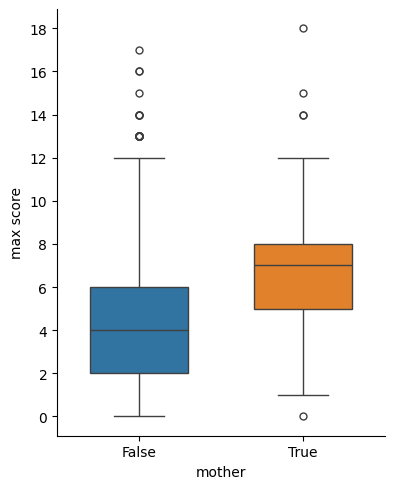

In [89]:
from matplotlib.ticker import MultipleLocator
g = sns.catplot(
    data = x,
    y = 'comp_max',
    x = 'mother',
    hue = 'mother',
    kind = 'box',
    width = 0.6,
    legend = False
)
g.ax.set_ylabel("max score")
g.ax.yaxis.set_major_locator(MultipleLocator(2))
g.fig.set_figwidth(4)

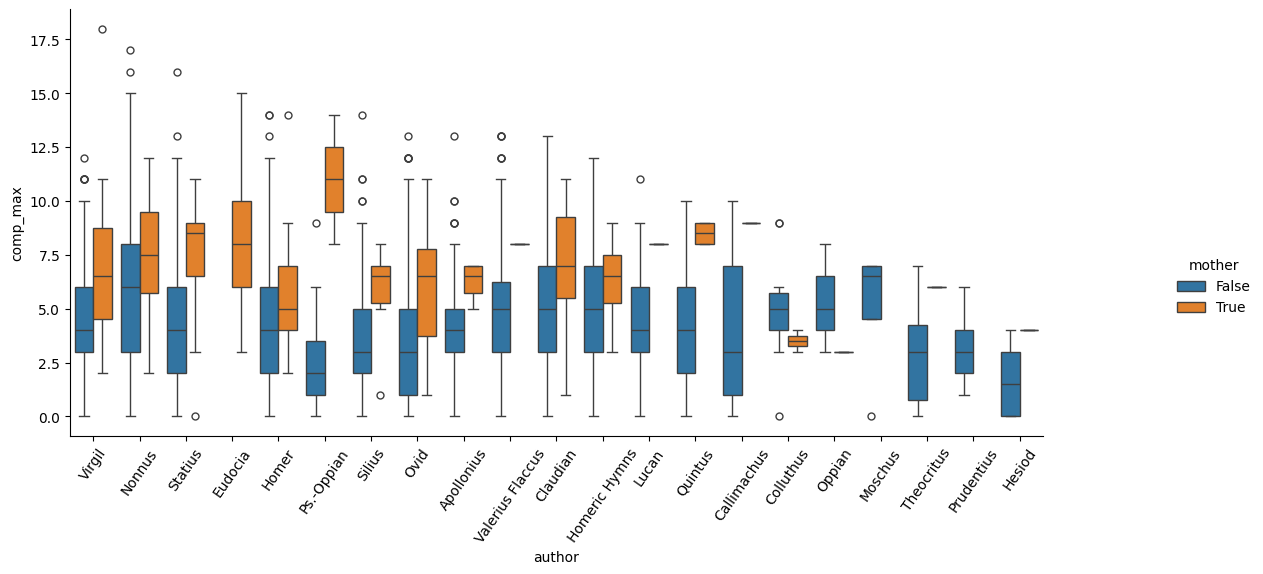

In [90]:
g = sns.catplot(data=x, y='comp_max', x='author', hue='mother', kind='box', dodge=True)
g.fig.set_figwidth(14)
g.ax.tick_params(axis="x", rotation=55)

## plot individual speeches

In [91]:
def linePlot(speech_id):
    mask = results['speech_id']==speech_id
    ys = results.loc[mask, 'comp']

    _, l_fi = ys.index.values[0].rsplit(':', 1)
    _, l_la = ys.index.values[-1].rsplit(':', 1)
    author = results.loc[mask, 'author'].iloc[0]
    work = results.loc[mask, 'work'].iloc[0]
    title = f"{author} {work} {l_fi}-{l_la}"

    if '.' in l_fi:
        _, l_fi = l_fi.rsplit('.', 1)
    l_fi = int(l_fi)
    xs = np.arange(l_fi, l_fi+len(ys))

    avg = results['comp'].median()

    fig, ax = plt.subplots(figsize=(8,5))
    ax.plot(xs, ys)
    ax.axhline(avg, color=sns.light_palette('#79C')[3], ls='--')
    ax.set_ylabel('rolling composite score')
    ax.set_xlabel('line')
    ax.yaxis.set_major_locator(MultipleLocator(2))
    ax.set_ylim((0,20))
    ax.set_title(title)
    plt.close(fig)
    return fig

def stackPlot(speech_id):
    mask = results['speech_id']==speech_id
    cols = ['family', 'imper', 'pers', 'interrog']
    df = results.loc[mask, cols]
    _, l_fi = df.index.values[0].rsplit(':', 1)
    _, l_la = df.index.values[-1].rsplit(':', 1)
    author = results.loc[mask, 'author'].iloc[0]
    work = results.loc[mask, 'work'].iloc[0]
    title = f"{author} {work} {l_fi}-{l_la}"

    if '.' in l_fi:
        _, l_fi = l_fi.rsplit('.', 1)
    l_fi = int(l_fi)
    xs = np.arange(l_fi, l_fi+len(df))
    df['line'] = xs

    avg = results['comp'].median()

    ax = df.plot.area(x='line', linewidth=0, figsize=(8,5))
    ax.axhline(avg, color='white', ls='--')
    ax.yaxis.set_major_locator(MultipleLocator(2))
    ax.set_ylim((0,20))
    ax.set_title(title)
    ax.set_ylabel('rolling score (5-line window)')
    ax.set_xlabel('line')
    fig = ax.figure
    plt.close(fig)
    return fig

def hl(col):
    return lambda string: f'<span style="font-weight:bold;color:{col}">{string}</span>'

def highlight(speech_id):
    mask = tokens['speech_id']==speech_id
    foo = pd.DataFrame(dict(
        line_id = tokens.loc[mask, 'line_id'],
        token = tokens.loc[mask, 'token_spacy'],
    ))
    foo.loc[tokens.loc[mask, 'family'], 'token'] = foo.loc[tokens.loc[mask, 'family'], 'token'].apply(hl('blue'))
    foo.loc[tokens.loc[mask, 'imper'], 'token'] = foo.loc[tokens.loc[mask, 'imper'], 'token'].apply(hl('orange'))
    foo.loc[tokens.loc[mask, 'pers'], 'token'] = foo.loc[tokens.loc[mask, 'pers'], 'token'].apply(hl('green'))
    foo.loc[tokens.loc[mask, 'interrog'], 'token'] = foo.loc[tokens.loc[mask, 'interrog'], 'token'].apply(hl('red'))

    html = '<table>' + '\n'.join(foo
        .groupby("line_id", sort=False)
        .agg(
            loc = ("line_id", lambda s: '<td>' + s.iloc[0].rsplit(':', 1)[1] + '</td>'),
            tokens = ("token", lambda s: '<td>' + ' '.join(s) + '<td>'),)
        .apply(lambda row: f'<tr>{row["loc"]}{row["tokens"]}</tr>', axis=1)
    ) + '</table>'

    return HTML(html)

def plotAndText(speech_id, filename="figure.png"):
    fig = stackPlot(speech_id)
    fig.savefig(filename)
    html = highlight(speech_id)
    display(fig, html)

## Examples for the article

#### Artemis to Aura

In [ ]:
plotAndText('3665')

#### Euryalus' mother

In [ ]:
plotAndText('1758')

#### Creon to Menoeceus

In [ ]:
plotAndText('3210')

#### Hecuba to Hector

In [ ]:
plotAndText('582')

#### Mary to Jesus

In [ ]:
plotAndText('4558')

#### Mother donkey

In [ ]:
plotAndText('4319')

#### Iris-Nyx

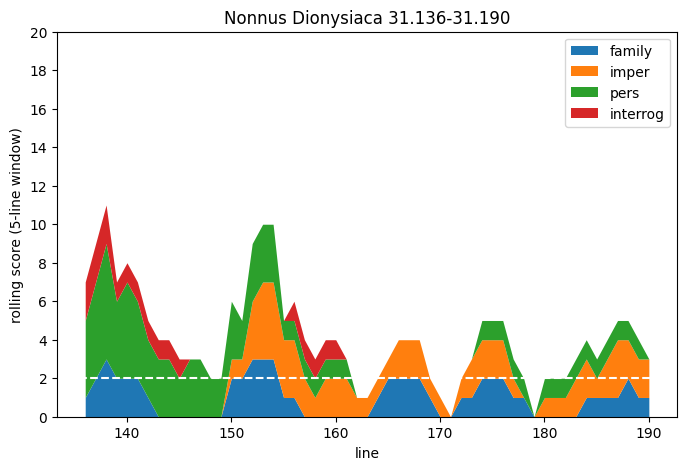

31.136
31.137
31.138
31.139
31.140
31.141
31.142
31.143
31.144
31.145
31.146


In [92]:
plotAndText('3501', "iris-nyx.png")

In [ ]:
results.groupby('speech_id', sort=False).agg(
    author = ('author', 'first'),
    work = ('work', 'first'),
    l_fi = ('l_fi', 'first'),
    l_la = ('l_la', 'first'),
    spkr = ('spkr', 'first'),
    addr = ('addr', 'first'),
    mother = ('mother', 'first'),
    lines = ('tokens', 'count'),
    tokens = ('tokens', 'sum'),
    comp_avg = ('comp', 'mean'),
    comp_sum = ('comp', 'sum'),
    comp_max = ('comp', 'max'),
).sort_values(["comp_max", "comp_avg"], ascending=False).query("comp_max>12")

In [72]:
tokens.query("speech_id=='3501'")[["line_id"]].to_clipboard()